 # Exploratory Data Analysis: Diabetes Prediction



 **Dataset**: CDC BRFSS 2015 Binary Health Indicators



 **Goal**: Understand feature distributions, relationships with target, and

 inform preprocessing/modeling decisions.



 ## Notebook Structure

 1. Data Loading & Validation

 2. Target Variable Analysis

 3. Univariate Distributions

 4. Bivariate Analysis (Features vs Target)

 5. Correlation Analysis

 6. Feature Interactions

 7. Summary & Modeling Implications

 ## 1. Data Loading & Validation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

FIGSIZE_SMALL = (8, 5)
FIGSIZE_MEDIUM = (12, 6)
FIGSIZE_LARGE = (14, 10)


In [14]:
# Load data
df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


DATA LOADING
Dataset shape: (253680, 22)
Memory usage: 42.6 MB


In [15]:
# Define feature groups
BINARY_FEATURES = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]
ORDINAL_FEATURES = ['GenHlth', 'Age', 'Education', 'Income']
NUMERIC_FEATURES = ['BMI', 'MentHlth', 'PhysHlth']
TARGET = 'Diabetes_binary'
ALL_FEATURES = BINARY_FEATURES + ORDINAL_FEATURES + NUMERIC_FEATURES


In [16]:
# Data validation checks
print("\n" + "=" * 60)
print("DATA VALIDATION")
print("=" * 60)

# Check 1: Null values
null_count = df.isnull().sum().sum()
print(f"\n✓ Null values: {null_count}")
assert null_count == 0, "Unexpected null values found!"

# Check 2: Binary features are 0/1
print("\n✓ Binary feature validation:")
for col in BINARY_FEATURES:
    valid = df[col].isin([0, 1]).all()
    assert valid, f"{col} has non-binary values"
print(f"  All {len(BINARY_FEATURES)} binary features confirmed as 0/1")

# Check 3: Ordinal ranges
print("\n✓ Ordinal feature ranges:")
ordinal_ranges = {'GenHlth': (1, 5), 'Age': (1, 13), 'Education': (1, 6), 'Income': (1, 8)}
for col, (low, high) in ordinal_ranges.items():
    valid = df[col].between(low, high).all()
    assert valid, f"{col} out of expected range [{low}, {high}]"
    print(f"  {col}: [{low}, {high}] ✓")

# Check 4: Numeric ranges
print("\n✓ Numeric feature ranges:")
assert df['BMI'].between(10, 100).all(), "BMI out of range"
print(f"  BMI: [{df['BMI'].min():.1f}, {df['BMI'].max():.1f}] ✓")
assert df['MentHlth'].between(0, 30).all(), "MentHlth out of range"
print(f"  MentHlth: [0, 30] ✓")
assert df['PhysHlth'].between(0, 30).all(), "PhysHlth out of range"
print(f"  PhysHlth: [0, 30] ✓")

# Check 5: Target is binary
assert df[TARGET].isin([0, 1]).all(), "Target is not binary"
print(f"\n✓ Target '{TARGET}' confirmed as binary")

print("\n" + "=" * 60)
print("ALL VALIDATION CHECKS PASSED")
print("=" * 60)



DATA VALIDATION

✓ Null values: 0

✓ Binary feature validation:
  All 14 binary features confirmed as 0/1

✓ Ordinal feature ranges:
  GenHlth: [1, 5] ✓
  Age: [1, 13] ✓
  Education: [1, 6] ✓
  Income: [1, 8] ✓

✓ Numeric feature ranges:
  BMI: [12.0, 98.0] ✓
  MentHlth: [0, 30] ✓
  PhysHlth: [0, 30] ✓

✓ Target 'Diabetes_binary' confirmed as binary

ALL VALIDATION CHECKS PASSED


 ## 2. Target Variable Analysis

In [17]:
target_counts = df[TARGET].value_counts().sort_index()
target_pcts = df[TARGET].value_counts(normalize=True).sort_index() * 100

print("\nTarget Distribution:")
print(f"  Class 0 (No Diabetes):  {target_counts[0]:,} ({target_pcts[0]:.1f}%)")
print(f"  Class 1 (Diabetes):     {target_counts[1]:,} ({target_pcts[1]:.1f}%)")
print(f"\nImbalance Ratio: {target_counts[0] / target_counts[1]:.1f}:1")



Target Distribution:
  Class 0 (No Diabetes):  218,334 (86.1%)
  Class 1 (Diabetes):     35,346 (13.9%)

Imbalance Ratio: 6.2:1


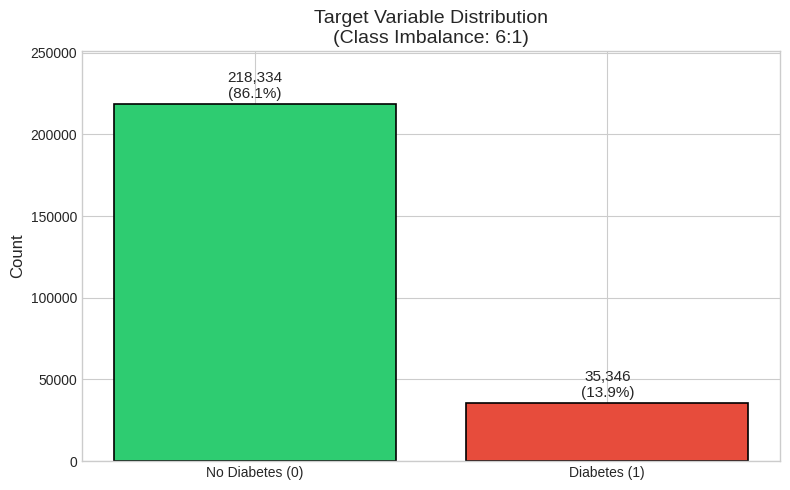

In [18]:
fig, ax = plt.subplots(figsize=FIGSIZE_SMALL)
bars = ax.bar(['No Diabetes (0)', 'Diabetes (1)'], target_counts.values, 
              color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.2)

for bar, count, pct in zip(bars, target_counts.values, target_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11)

ax.set_ylabel('Count', fontsize=12)
ax.set_title('Target Variable Distribution\n(Class Imbalance: 6:1)', fontsize=14)
ax.set_ylim(0, target_counts.max() * 1.15)
plt.tight_layout()
plt.savefig('img/fig_eda_target_distribution.png', dpi=150)
plt.show()


 ## 3. Univariate Distributions

 ### 3a. Numeric Features

In [19]:
print("Numeric Feature Summary:")
print(df[NUMERIC_FEATURES].describe().round(2))

print("\nSkewness:")
for col in NUMERIC_FEATURES:
    skew = df[col].skew()
    label = '(right-skewed)' if skew > 1 else '(moderate)' if skew > 0.5 else '(symmetric)'
    print(f"  {col}: {skew:.2f} {label}")


Numeric Feature Summary:
             BMI   MentHlth   PhysHlth
count  253680.00  253680.00  253680.00
mean       28.38       3.18       4.24
std         6.61       7.41       8.72
min        12.00       0.00       0.00
25%        24.00       0.00       0.00
50%        27.00       0.00       0.00
75%        31.00       2.00       3.00
max        98.00      30.00      30.00

Skewness:
  BMI: 2.12 (right-skewed)
  MentHlth: 2.72 (right-skewed)
  PhysHlth: 2.21 (right-skewed)


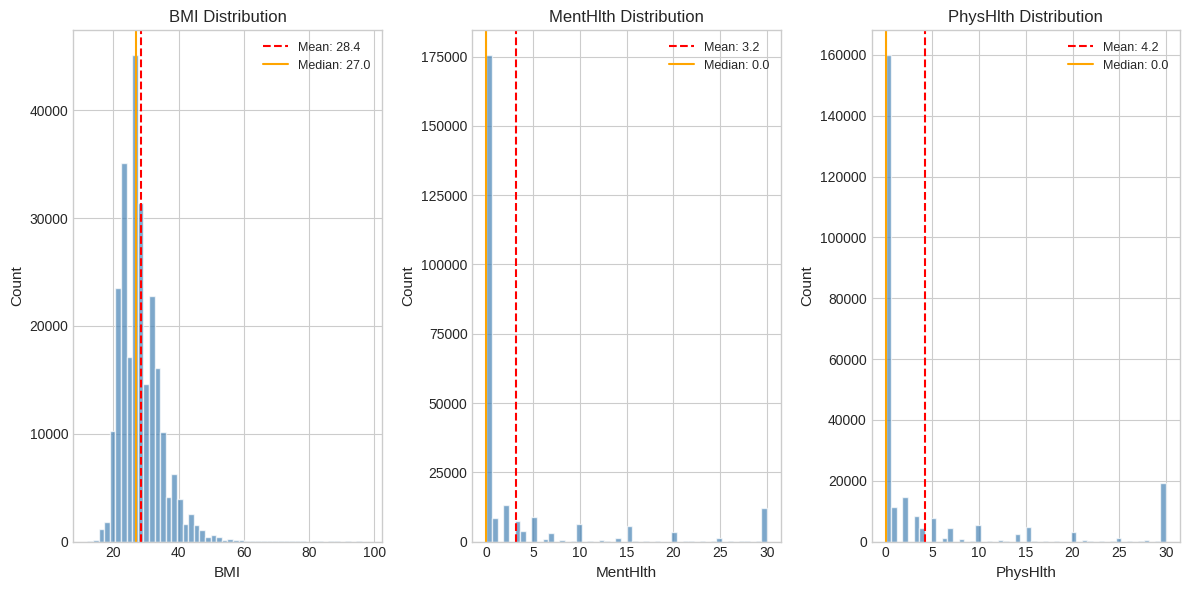

In [20]:
fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_MEDIUM)
for ax, col in zip(axes, NUMERIC_FEATURES):
    ax.hist(df[col], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    ax.axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.1f}')
    ax.axvline(df[col].median(), color='orange', linestyle='-', label=f'Median: {df[col].median():.1f}')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.legend(fontsize=9)
    ax.set_title(f'{col} Distribution', fontsize=12)
plt.tight_layout()
plt.savefig('img/fig_eda_numeric_distributions.png', dpi=150)
plt.show()


 ### 3b. Ordinal Features

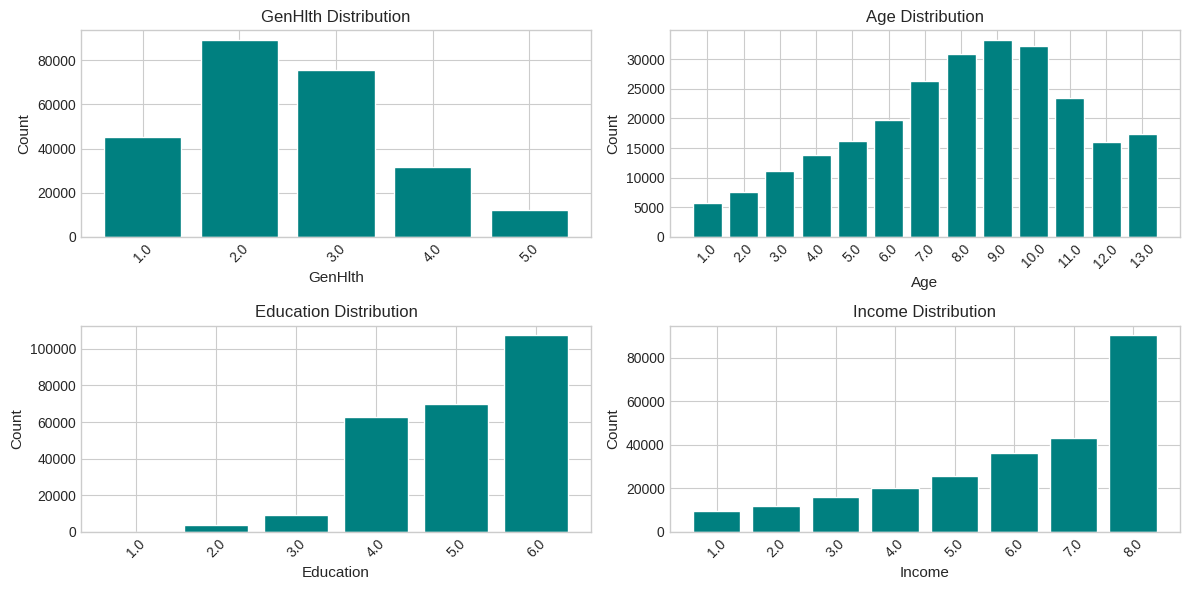

In [21]:
fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_MEDIUM)
axes = axes.flatten()
for ax, col in zip(axes, ORDINAL_FEATURES):
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values, color='teal', edgecolor='white')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'{col} Distribution', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('img/fig_eda_ordinal_distributions.png', dpi=150)
plt.show()


 ### 3c. Binary Features

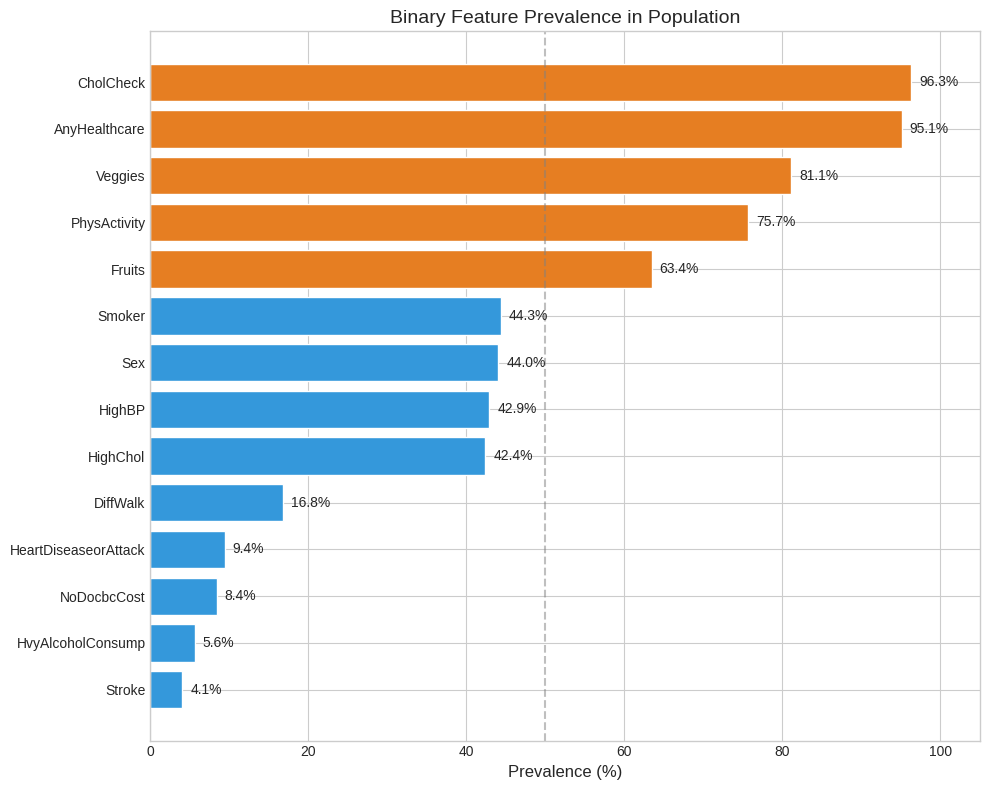

In [22]:
binary_prevalence = df[BINARY_FEATURES].mean().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#3498db' if x < 0.5 else '#e67e22' for x in binary_prevalence.values]
bars = ax.barh(binary_prevalence.index, binary_prevalence.values * 100, color=colors, edgecolor='white')

for bar, val in zip(bars, binary_prevalence.values):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{val*100:.1f}%', va='center', fontsize=10)

ax.set_xlabel('Prevalence (%)', fontsize=12)
ax.set_title('Binary Feature Prevalence in Population', fontsize=14)
ax.set_xlim(0, 105)
ax.axvline(50, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('img/fig_eda_binary_prevalence.png', dpi=150)
plt.show()


 ## 4. Bivariate Analysis: Features vs Target

 ### 4a. Binary Features vs Target

In [23]:
diabetes_rates = {}
for col in BINARY_FEATURES:
    rates = df.groupby(col)[TARGET].mean() * 100
    diabetes_rates[col] = {
        'rate_0': rates[0], 'rate_1': rates[1],
        'diff': rates[1] - rates[0],
        'ratio': rates[1] / rates[0] if rates[0] > 0 else np.inf
    }

diabetes_rates_df = pd.DataFrame(diabetes_rates).T
diabetes_rates_df.columns = ['Rate (0)', 'Rate (1)', 'Difference', 'Risk Ratio']
diabetes_rates_df = diabetes_rates_df.sort_values('Difference', ascending=False)

print("Diabetes Rate by Binary Feature (%):")
print(diabetes_rates_df.round(2))


Diabetes Rate by Binary Feature (%):
                      Rate (0)  Rate (1)  Difference  Risk Ratio
HeartDiseaseorAttack     11.95     32.97       21.02        2.76
DiffWalk                 10.53     30.75       20.21        2.92
Stroke                   13.18     31.75       18.57        2.41
HighBP                    6.04     24.45       18.41        4.05
HighChol                  7.98     22.01       14.03        2.76
CholCheck                 2.54     14.37       11.83        5.65
Smoker                   12.06     16.29        4.24        1.35
NoDocbcCost              13.60     17.52        3.92        1.29
AnyHealthcare            11.45     14.06        2.61        1.23
Sex                      12.97     15.16        2.19        1.17
Fruits                   15.79     12.86       -2.93        0.81
Veggies                  18.00     12.99       -5.01        0.72
HvyAlcoholConsump        14.42      5.84       -8.58        0.40
PhysActivity             21.14     11.61       -9.53 

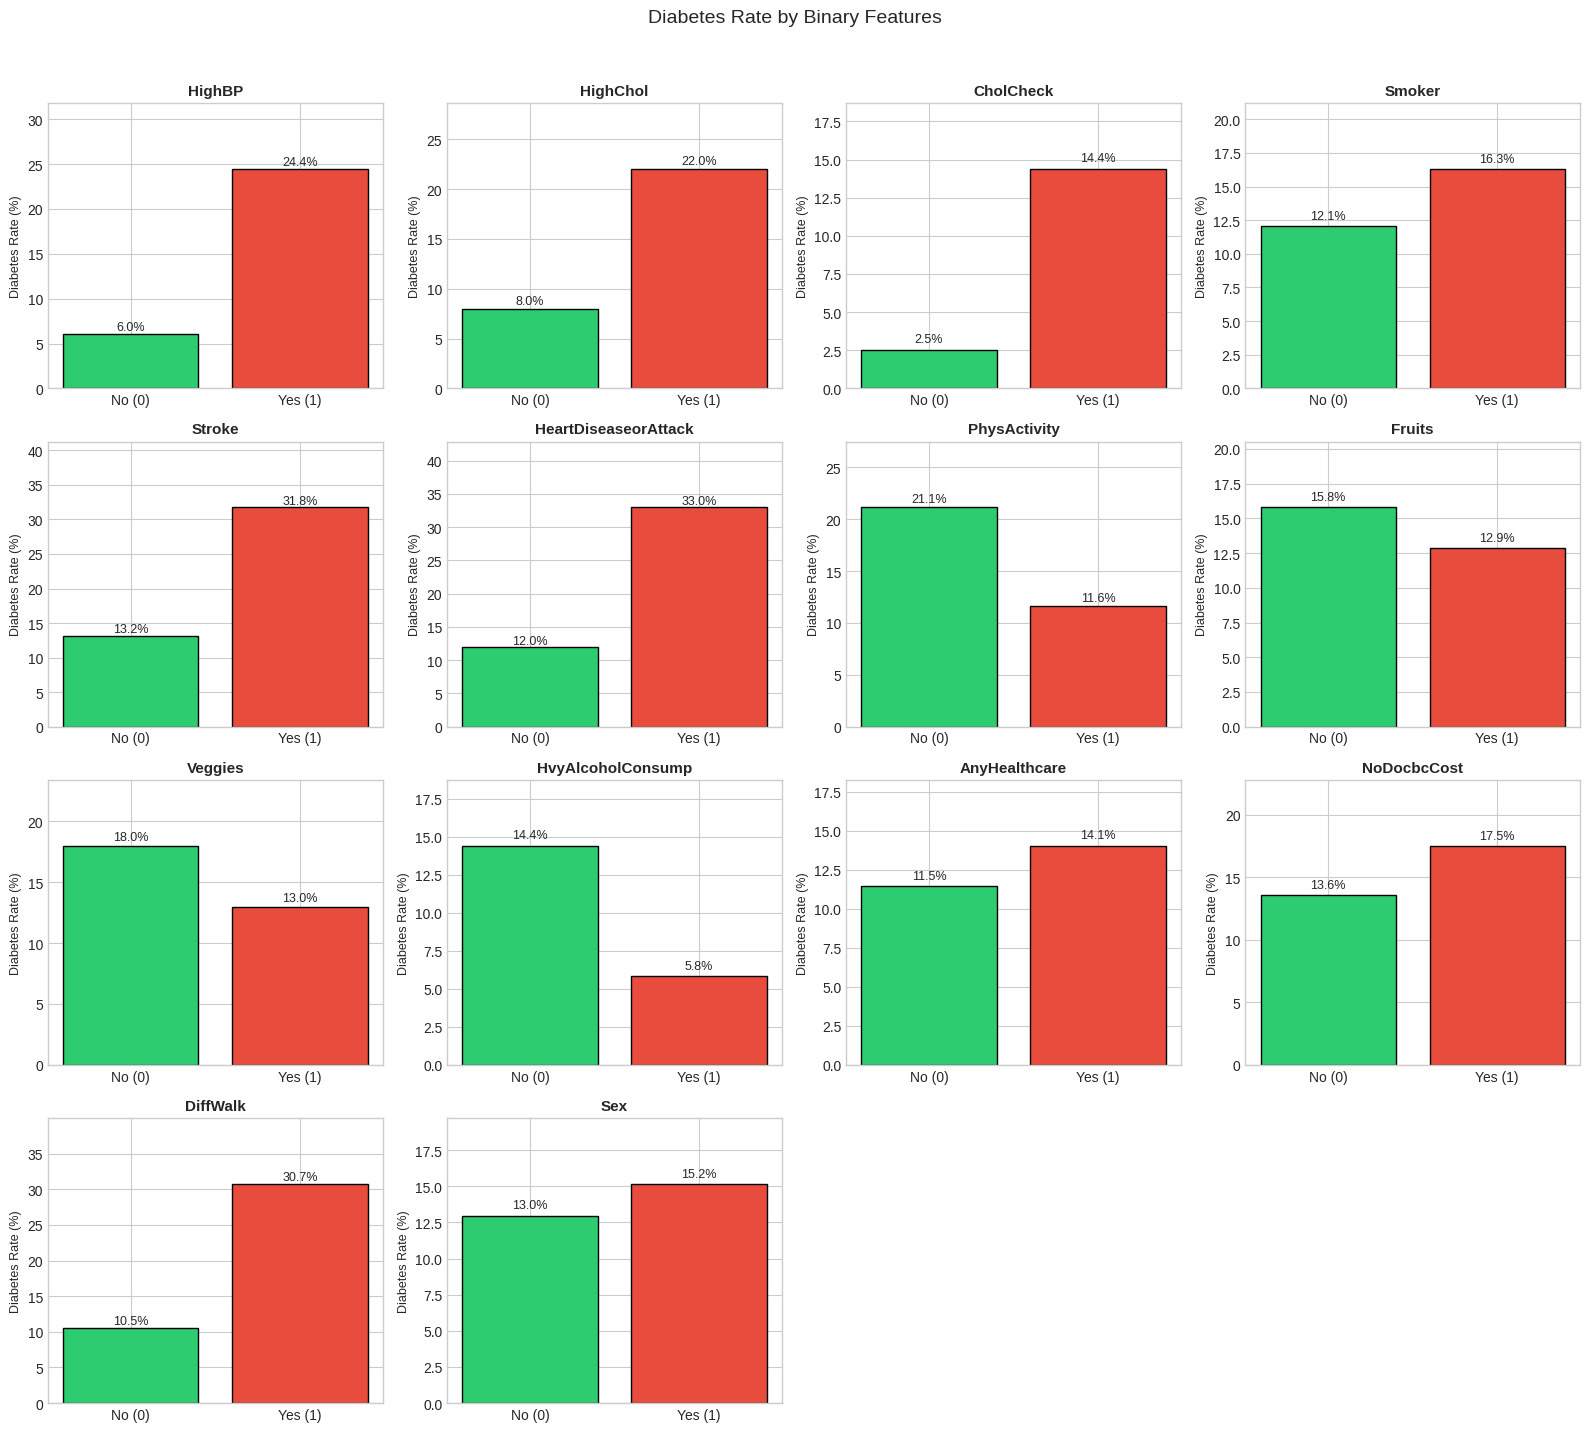

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()

for idx, col in enumerate(BINARY_FEATURES):
    ax = axes[idx]
    rates = df.groupby(col)[TARGET].mean() * 100
    bars = ax.bar(['No (0)', 'Yes (1)'], rates.values, color=['#2ecc71', '#e74c3c'], edgecolor='black')
    for bar, rate in zip(bars, rates.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{rate:.1f}%', ha='center', fontsize=9)
    ax.set_ylabel('Diabetes Rate (%)', fontsize=9)
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(rates.values) * 1.3)

for idx in range(len(BINARY_FEATURES), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Diabetes Rate by Binary Features', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('img/fig_eda_binary_vs_target.png', dpi=150)
plt.show()


 ### 4b. Numeric Features vs Target

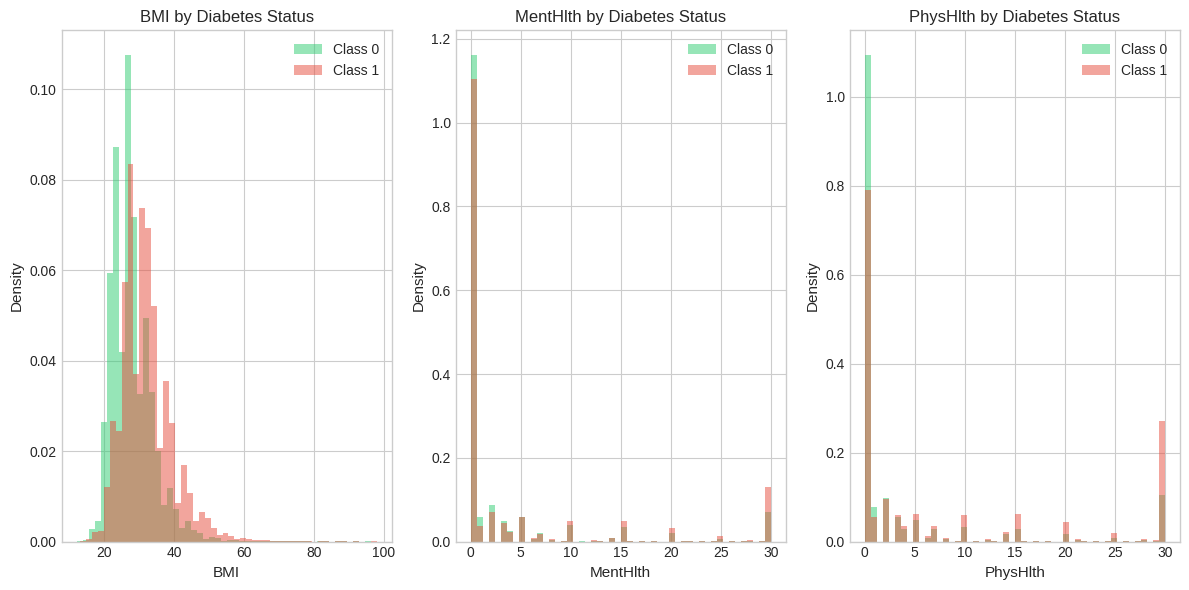

In [25]:
fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_MEDIUM)
for ax, col in zip(axes, NUMERIC_FEATURES):
    for label, color in [(0, '#2ecc71'), (1, '#e74c3c')]:
        data = df[df[TARGET] == label][col]
        ax.hist(data, bins=50, alpha=0.5, label=f'Class {label}', color=color, density=True)
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{col} by Diabetes Status', fontsize=12)
    ax.legend()
plt.tight_layout()
plt.savefig('img/fig_eda_numeric_vs_target.png', dpi=150)
plt.show()


In [26]:
print("Numeric Features: Class Comparison")
print("-" * 60)
for col in NUMERIC_FEATURES:
    mean_0 = df[df[TARGET] == 0][col].mean()
    mean_1 = df[df[TARGET] == 1][col].mean()
    t_stat, p_val = stats.ttest_ind(df[df[TARGET] == 0][col], df[df[TARGET] == 1][col])
    print(f"\n{col}:")
    print(f"  No Diabetes Mean: {mean_0:.2f}")
    print(f"  Diabetes Mean:    {mean_1:.2f}")
    print(f"  Difference:       {mean_1 - mean_0:.2f}")
    print(f"  P-value:          {p_val:.2e} {'***' if p_val < 0.001 else ''}")


Numeric Features: Class Comparison
------------------------------------------------------------

BMI:
  No Diabetes Mean: 27.81
  Diabetes Mean:    31.94
  Difference:       4.14
  P-value:          0.00e+00 ***

MentHlth:
  No Diabetes Mean: 2.98
  Diabetes Mean:    4.46
  Difference:       1.48
  P-value:          1.14e-267 ***

PhysHlth:
  No Diabetes Mean: 3.64
  Diabetes Mean:    7.95
  Difference:       4.31
  P-value:          0.00e+00 ***


 ### 4c. Ordinal Features vs Target

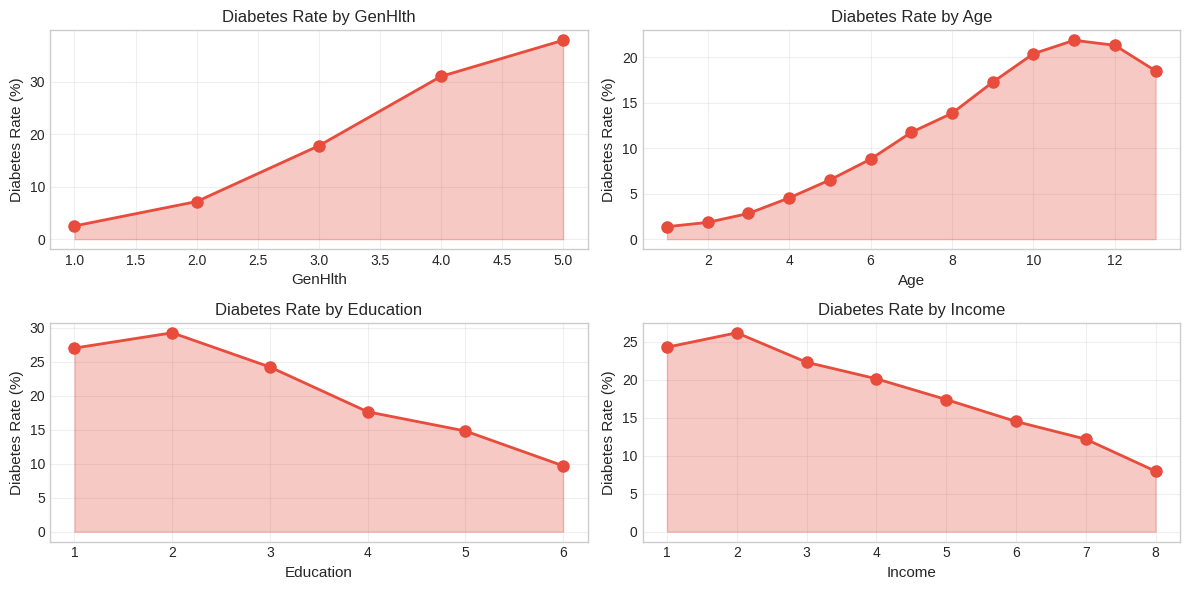

In [27]:
fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_MEDIUM)
axes = axes.flatten()
for ax, col in zip(axes, ORDINAL_FEATURES):
    rates = df.groupby(col)[TARGET].mean() * 100
    ax.plot(rates.index, rates.values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
    ax.fill_between(rates.index, rates.values, alpha=0.3, color='#e74c3c')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Diabetes Rate (%)', fontsize=11)
    ax.set_title(f'Diabetes Rate by {col}', fontsize=12)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('img/fig_eda_ordinal_vs_target.png', dpi=150)
plt.show()


 ## 5. Correlation Analysis

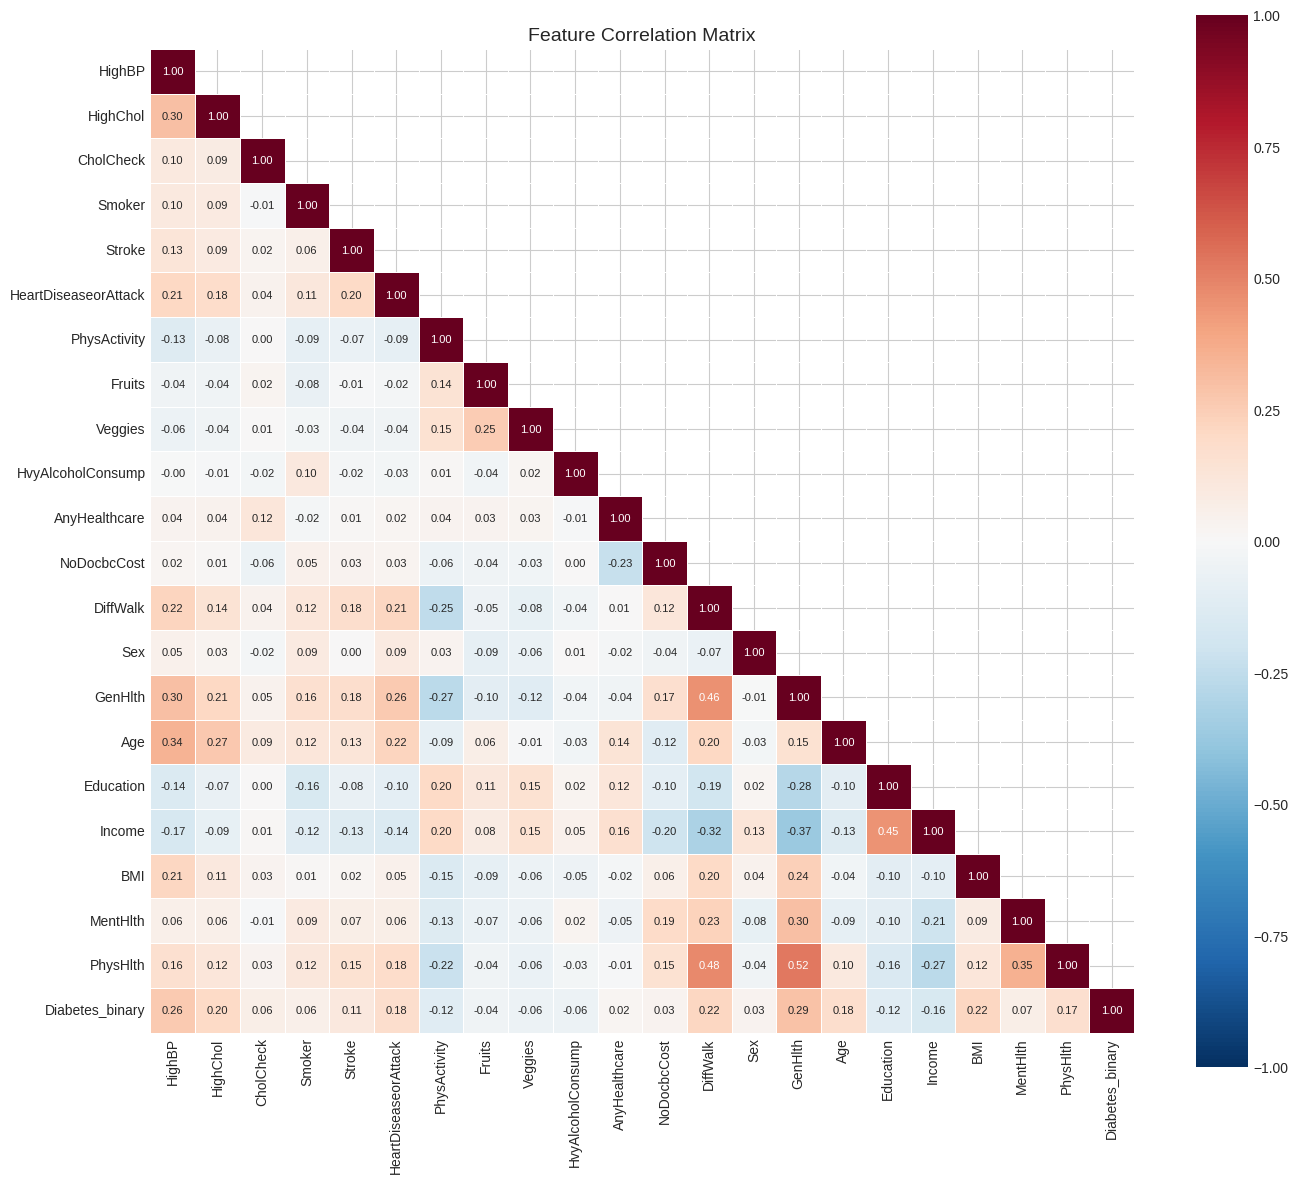

In [28]:
corr_matrix = df[ALL_FEATURES + [TARGET]].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax, annot_kws={'size': 8}, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('img/fig_eda_correlation_matrix.png', dpi=150)
plt.show()


In [29]:
target_corr = corr_matrix[TARGET].drop(TARGET).sort_values(key=abs, ascending=False)

print("Feature Correlations with Diabetes (sorted by absolute value):")
print("-" * 50)
for feature, corr in target_corr.items():
    direction = "+" if corr > 0 else "-"
    strength = "strong" if abs(corr) > 0.3 else "moderate" if abs(corr) > 0.15 else "weak"
    print(f"  {feature:25} {corr:+.3f}  ({direction}, {strength})")


Feature Correlations with Diabetes (sorted by absolute value):
--------------------------------------------------
  GenHlth                   +0.294  (+, moderate)
  HighBP                    +0.263  (+, moderate)
  DiffWalk                  +0.218  (+, moderate)
  BMI                       +0.217  (+, moderate)
  HighChol                  +0.200  (+, moderate)
  Age                       +0.177  (+, moderate)
  HeartDiseaseorAttack      +0.177  (+, moderate)
  PhysHlth                  +0.171  (+, moderate)
  Income                    -0.164  (-, moderate)
  Education                 -0.124  (-, weak)
  PhysActivity              -0.118  (-, weak)
  Stroke                    +0.106  (+, weak)
  MentHlth                  +0.069  (+, weak)
  CholCheck                 +0.065  (+, weak)
  Smoker                    +0.061  (+, weak)
  HvyAlcoholConsump         -0.057  (-, weak)
  Veggies                   -0.057  (-, weak)
  Fruits                    -0.041  (-, weak)
  NoDocbcCost         

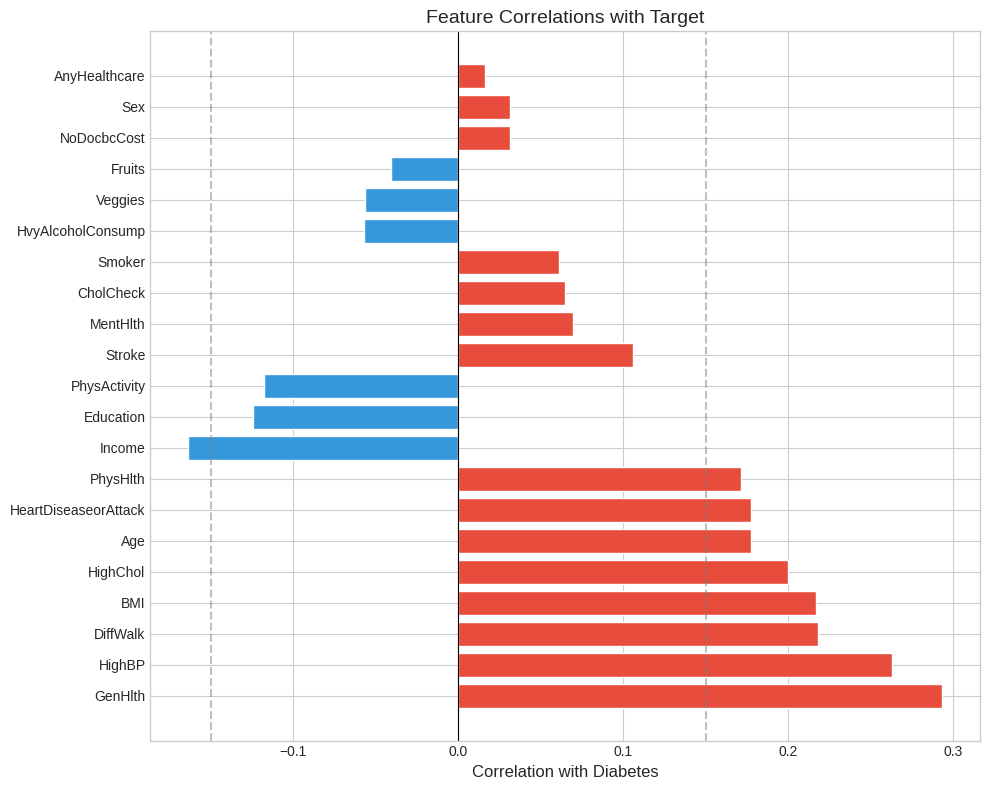

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in target_corr.values]
ax.barh(target_corr.index, target_corr.values, color=colors, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
ax.axvline(0.15, color='gray', linestyle='--', alpha=0.5)
ax.axvline(-0.15, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Correlation with Diabetes', fontsize=12)
ax.set_title('Feature Correlations with Target', fontsize=14)
plt.tight_layout()
plt.savefig('img/fig_eda_target_correlations.png', dpi=150)
plt.show()


 ## 6. Feature Interactions

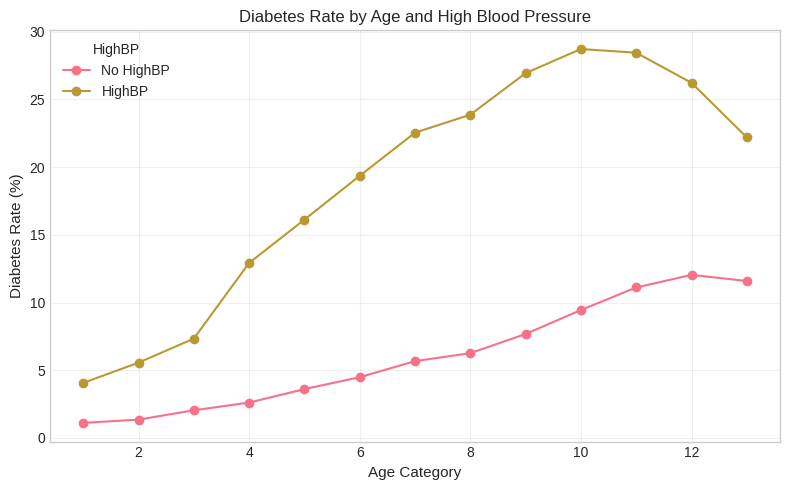

In [31]:
# Age × HighBP interaction
interaction_df = df.groupby(['Age', 'HighBP'])[TARGET].mean().unstack() * 100

fig, ax = plt.subplots(figsize=FIGSIZE_SMALL)
interaction_df.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Age Category', fontsize=11)
ax.set_ylabel('Diabetes Rate (%)', fontsize=11)
ax.set_title('Diabetes Rate by Age and High Blood Pressure', fontsize=12)
ax.legend(['No HighBP', 'HighBP'], title='HighBP')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('img/fig_eda_interaction_age_bp.png', dpi=150)
plt.show()


/tmp/ipykernel_20451/2011894381.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interaction_df2 = df.groupby(['BMI_bin', 'PhysActivity'])[TARGET].mean().unstack() * 100


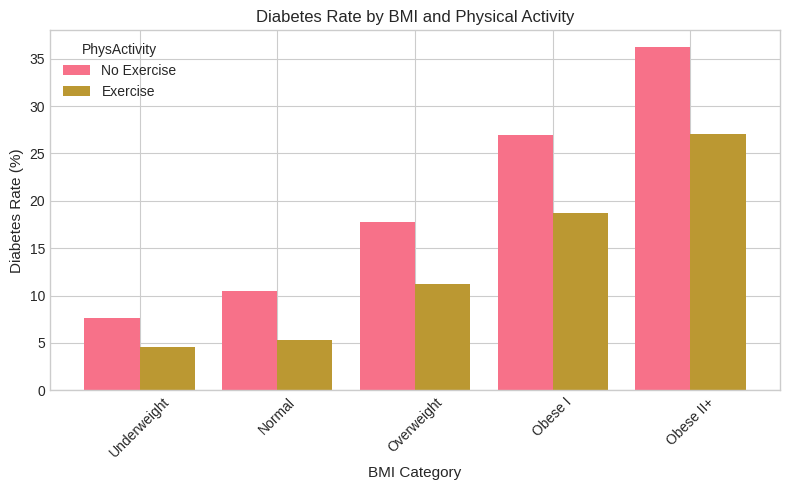

In [32]:
# BMI × PhysActivity interaction
df['BMI_bin'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 35, 100], 
                       labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+'])

interaction_df2 = df.groupby(['BMI_bin', 'PhysActivity'])[TARGET].mean().unstack() * 100

fig, ax = plt.subplots(figsize=FIGSIZE_SMALL)
interaction_df2.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('BMI Category', fontsize=11)
ax.set_ylabel('Diabetes Rate (%)', fontsize=11)
ax.set_title('Diabetes Rate by BMI and Physical Activity', fontsize=12)
ax.legend(['No Exercise', 'Exercise'], title='PhysActivity')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('img/fig_eda_interaction_bmi_activity.png', dpi=150)
plt.show()

df.drop('BMI_bin', axis=1, inplace=True)


 ## 7. Summary & Modeling Implications

In [33]:
print("=" * 70)
print("EDA SUMMARY: Key Findings for Diabetes Prediction")
print("=" * 70)

print("\n1. TARGET IMBALANCE:")
print(f"   - {target_pcts[0]:.1f}% No Diabetes vs {target_pcts[1]:.1f}% Diabetes ({target_counts[0]/target_counts[1]:.1f}:1 ratio)")
print(f"   - Imbalance handling required (SMOTE, class weights, or undersampling)")

print("\n2. TOP PREDICTIVE FEATURES (by correlation):")
for i, (feat, corr) in enumerate(target_corr.head(5).items(), 1):
    print(f"   {i}. {feat}: {corr:+.3f}")

print("\n3. NUMERIC FEATURE INSIGHTS:")
for col in NUMERIC_FEATURES:
    mean_diff = df[df[TARGET]==1][col].mean() - df[df[TARGET]==0][col].mean()
    direction = 'higher' if mean_diff > 0 else 'lower'
    print(f"   - {col}: Diabetics have {abs(mean_diff):.1f} {direction} average")

print("\n4. HIGH-RISK BINARY INDICATORS:")
high_risk = diabetes_rates_df.nlargest(3, 'Risk Ratio')
for col in high_risk.index:
    ratio = diabetes_rates[col]['ratio']
    print(f"   - {col}: {ratio:.1f}x higher diabetes risk when present")

print("\n5. FEATURE INTERACTIONS:")
print("   - Age × HighBP: Strong interaction (older + HighBP = highest risk)")
print("   - BMI × PhysActivity: Exercise reduces risk across all BMI categories")

print("\n6. MODELING IMPLICATIONS:")
print("   - Class imbalance: Consider SMOTE, class weights, or undersampling")
print("   - Strong linear correlations → Logistic Regression viable")
print("   - Interactions present → Tree-based models may capture non-linearities")
print("   - Mixed feature types (14 binary + 4 ordinal + 3 numeric) → Ensembles favorable")

print("\n" + "=" * 70)
print("EDA COMPLETE - Proceed to preprocessing")
print("=" * 70)

EDA SUMMARY: Key Findings for Diabetes Prediction

1. TARGET IMBALANCE:
   - 86.1% No Diabetes vs 13.9% Diabetes (6.2:1 ratio)
   - Imbalance handling required (SMOTE, class weights, or undersampling)

2. TOP PREDICTIVE FEATURES (by correlation):
   1. GenHlth: +0.294
   2. HighBP: +0.263
   3. DiffWalk: +0.218
   4. BMI: +0.217
   5. HighChol: +0.200

3. NUMERIC FEATURE INSIGHTS:
   - BMI: Diabetics have 4.1 higher average
   - MentHlth: Diabetics have 1.5 higher average
   - PhysHlth: Diabetics have 4.3 higher average

4. HIGH-RISK BINARY INDICATORS:
   - CholCheck: 5.6x higher diabetes risk when present
   - HighBP: 4.1x higher diabetes risk when present
   - DiffWalk: 2.9x higher diabetes risk when present

5. FEATURE INTERACTIONS:
   - Age × HighBP: Strong interaction (older + HighBP = highest risk)
   - BMI × PhysActivity: Exercise reduces risk across all BMI categories

6. MODELING IMPLICATIONS:
   - Class imbalance: Consider SMOTE, class weights, or undersampling
   - Strong li